In [1]:
#Import Required Libraries
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report 
import seaborn as sns
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.ensemble import AdaBoostClassifier

In [2]:
def plot_learning_curve_hyper(df, x_axis_label, y_axis_label, title, ax=None, ylim=None):
  x = []
  for ele in df.params:
    for k, v in ele.items():
      x.append(v)
  if ax is None:
    _, ax = plt.subplots(figsize=(14, 10))

  ax.set_title(title)
  if ylim is not None:
    ax.set_ylim(*ylim)
  ax.set_xlabel(x_axis_label)
  ax.set_ylabel(y_axis_label)
  ax.grid()
  ax.fill_between(
    x,
    (df['mean_train_score'] - df['std_train_score']).values,
    (df['mean_train_score'] + df['std_train_score']).values,
    alpha=0.1,
    color="r",
    )
  ax.fill_between(
    x,
    (df['mean_test_score'] - df['std_test_score']).values,
    (df['mean_test_score'] + df['std_test_score']).values,
    alpha=0.1,
    color="g",
    )
  ax.plot(x, df['mean_train_score'], "x-", color = 'r', label = 'Training Score')
  ax.plot(x, df['mean_test_score'], "x-", color = 'g', label = 'Cross-validation Score')
  ax.legend(loc="best")

In [3]:
def plot_learning_curve(model, X, y, X_train=None, X_val=None, y_train=None, y_val=None):

  if X_train is None: 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=27)
  train_errors, val_errors = [], []
  train_size = np.linspace(30, len(X_train), 13).astype(int)
  for m in train_size:
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)

    train_errors.append(f1_score(y_train[:m], y_train_predict, average='macro'))
    val_errors.append(f1_score(y_val, y_val_predict, average= 'macro'))
  plt.grid()
  plt.plot(train_size, train_errors, 'r', label= 'Training Error')
  plt.plot(train_size, val_errors, 'b', label = 'Validation Error')
  plt.ylabel('F1 Macro Score')
  plt.xlabel('Training Example Size')
  plt.legend(loc='best')

In [4]:
def up_sampling(X_train, y_train):
  #Concatonate our our training data back together
  X = pd.concat([X_train, y_train], axis=1)
  #Seprate Minority and Majority Class
  opened_account = X[X['Personal Loan'] == 1]
  not_opened_account = X[X['Personal Loan'] == 0]
  #Upsample the Minority Class
  opened_account_upsampled = resample(opened_account,
                                      replace = True, #sample with replacement
                                      n_samples= len(not_opened_account), #match the number of not opened account
                                      random_state = 27)
  upsampled = pd.concat([opened_account_upsampled, not_opened_account])
  return upsampled

In [5]:
#Mount to Google Drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
% cd /content/drive/MyDrive/Georgia Tech/Machine Learning-CS7641/Assignments/Assignment #1/Loan_Model_DT

/content/drive/MyDrive/Georgia Tech/Machine Learning-CS7641/Assignments/Assignment #1/Loan_Model_DT


In [7]:
df = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx', sheet_name='Data')

In [8]:
X = df.drop(['Personal Loan', 'ID', 'ZIP Code'], axis=1)
y = df['Personal Loan']

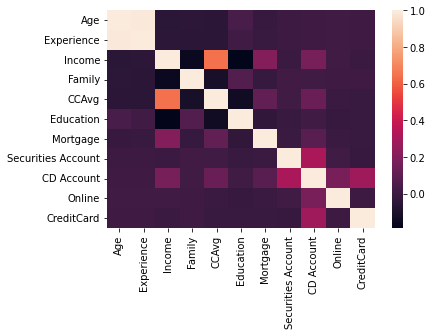

In [9]:
# Checking Corelation heatmap
import seaborn as sns
corr = X.corr()
sns.heatmap(corr)

In [10]:
#Dropping Age column for colinearity
X.drop('Age', axis=1, inplace=True)

In [11]:
#Split the dataset to train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25,
                                                    random_state=27,stratify=y)

In [12]:
print(y_train.value_counts())
print(y_test.value_counts())

0    3390
1     360
Name: Personal Loan, dtype: int64
0    1130
1     120
Name: Personal Loan, dtype: int64


In [13]:
#Group Columns based on type
normal_col = ['Experience']
skewd_col = ['Income', 'CCAvg', 'Mortgage']
cat_col = ['Family', 'Education']

In [14]:
#Make Copy of X_train and X_test
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer

normal_pipeline = Pipeline(steps = [('scale', StandardScaler())])
skewd_pipline = Pipeline(steps = [('sk_scale', PowerTransformer())])
cat_pipeline = Pipeline(steps=[('one_hot', OneHotEncoder())])

full_preprocessor = ColumnTransformer(transformers=[
        ('normal_transform', normal_pipeline, normal_col),
        ('skewd_transform', skewd_pipline, skewd_col),
        ('Categorical_onhot', cat_pipeline, cat_col)],remainder ='passthrough')

X_train_stand = full_preprocessor.fit_transform(X_train_stand)
X_test_stand = full_preprocessor.transform(X_test_stand)

In [16]:
# Try a quick and dirty Adaboost Algorithm Based with Decision tree

clf_ada = AdaBoostClassifier(random_state=0)

clf_ada.fit(X_train, y_train)

y_pred = clf_ada.predict(X_test)  

In [17]:
print(f'Classification Report on Test using Naive Adaboost(Decision Tree):\n\n {classification_report(y_pred, y_test)}')

Classification Report on Test using Naive Adaboost(Decision Tree):

               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1147
           1       0.78      0.91      0.84       103

    accuracy                           0.97      1250
   macro avg       0.89      0.94      0.91      1250
weighted avg       0.97      0.97      0.97      1250



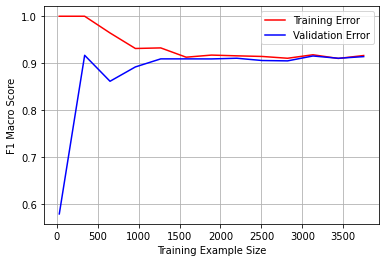

In [18]:
plot_learning_curve(clf_ada, X, y)

In [19]:
y_pop = clf_ada.predict(X_train)
print(f'Classification Report on Test using Naive Adaboost(Decision Tree):\n\n {classification_report(y_pop, y_train)}')

Classification Report on Test using Naive Adaboost(Decision Tree):

               precision    recall  f1-score   support

           0       0.99      0.98      0.99      3442
           1       0.79      0.92      0.85       308

    accuracy                           0.97      3750
   macro avg       0.89      0.95      0.92      3750
weighted avg       0.98      0.97      0.97      3750



In [ ]:
# Try a quick and dirty Adaboost Algorithm Based with Decision tree
from sklearn.svm import SVC

clf_ada = AdaBoostClassifier(random_state=0, base_estimator= SVC(random_state= 0,
                                                            probability=True))

clf_ada.fit(X_train, y_train)

y_pred = clf_ada.predict(X_test)  

In [ ]:
print(f'Classification Report on Test using Naive Adaboost(SVC):\n\n {classification_report(y_pred, y_test, zero_division=1)}')

In [21]:
#Optimizing Base Estimator Parameters

base_est = DecisionTreeClassifier(random_state=0)

param_grid = {'base_estimator__criterion': ['gini', 'entropy']}

clf_ada = AdaBoostClassifier(base_estimator=base_est, random_state=0)

grid_search = GridSearchCV(clf_ada, param_grid= param_grid,
                           scoring = 'f1_macro', return_train_score=True, cv=5)

grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0),
                                          random_state=0),
             param_grid={'base_estimator__criterion': ['gini', 'entropy']},
             return_train_score=True, scoring='f1_macro')

In [22]:
df_base_criterion = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'base_estimator__criterion': 'entropy'}

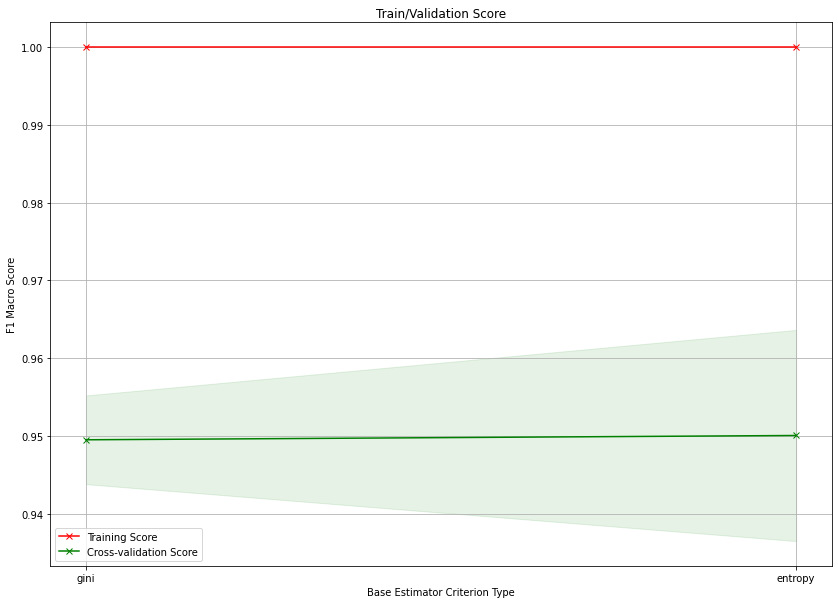

In [23]:
plot_learning_curve_hyper(df_base_criterion, 'Base Estimator Criterion Type', 
                          'F1 Macro Score', 'Train/Validation Score')

In [24]:
#Optimizing Base Estimator Parameters

base_est = DecisionTreeClassifier(random_state=0)

param_grid = {'base_estimator__splitter': ['best', 'random']}

clf_ada = AdaBoostClassifier(base_estimator=base_est, random_state=0)

grid_search = GridSearchCV(clf_ada, param_grid= param_grid,
                           scoring = 'f1_macro', return_train_score=True, cv=5)

grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0),
                                          random_state=0),
             param_grid={'base_estimator__splitter': ['best', 'random']},
             return_train_score=True, scoring='f1_macro')

In [25]:
df_base_splitter = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'base_estimator__splitter': 'best'}

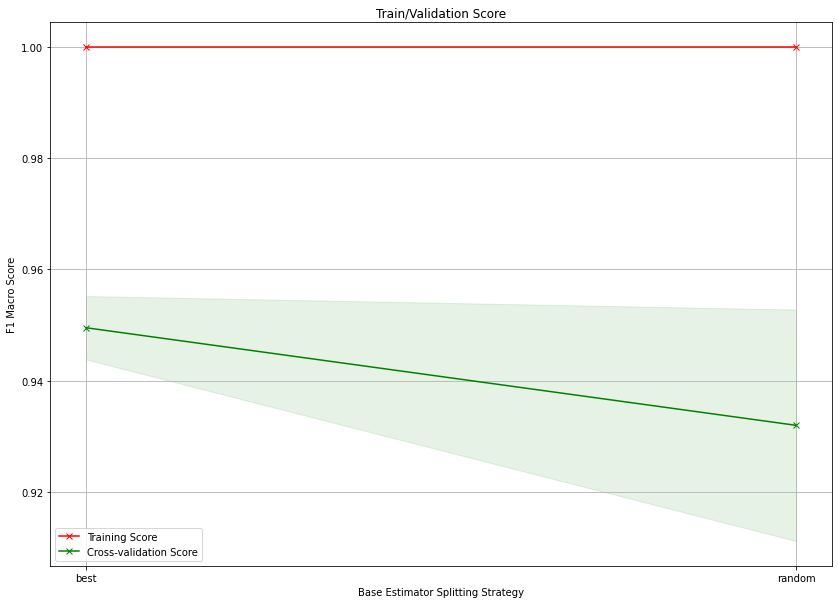

In [26]:
plot_learning_curve_hyper(df_base_splitter, 'Base Estimator Splitting Strategy', 
                          'F1 Macro Score', 'Train/Validation Score')

In [27]:
#Optimizing Base Estimator Parameters

base_est = DecisionTreeClassifier(random_state=0)

param_grid = {'base_estimator__max_depth': [i for i in range(2,10)]}

clf_ada = AdaBoostClassifier(base_estimator=base_est, random_state=0)

grid_search = GridSearchCV(clf_ada, param_grid= param_grid,
                           scoring = 'f1_macro', return_train_score=True, cv=5)

grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0),
                                          random_state=0),
             param_grid={'base_estimator__max_depth': [2, 3, 4, 5, 6, 7, 8, 9]},
             return_train_score=True, scoring='f1_macro')

In [28]:
df_base_depth = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'base_estimator__max_depth': 7}

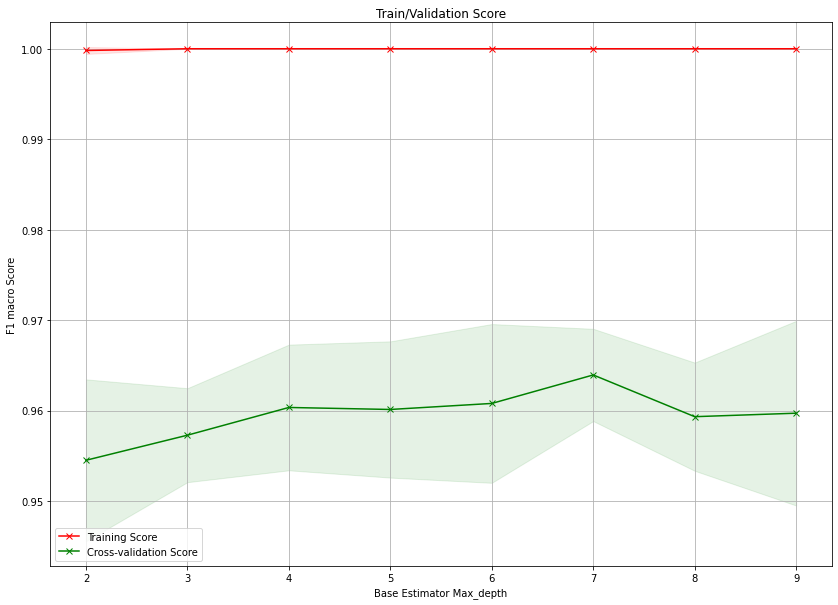

In [29]:
plot_learning_curve_hyper(df_base_depth, 'Base Estimator Max_depth', 
                          'F1 macro Score', 'Train/Validation Score')

In [30]:
#Optimizing Base Estimator Parameters

base_est = DecisionTreeClassifier(random_state=0)

param_grid = {'base_estimator__min_samples_split': [i for i in range(2,10,2)]}

clf_ada = AdaBoostClassifier(base_estimator=base_est, random_state=0)

grid_search = GridSearchCV(clf_ada, param_grid= param_grid,
                           scoring = 'f1_macro', return_train_score=True, cv=5)

grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0),
                                          random_state=0),
             param_grid={'base_estimator__min_samples_split': [2, 4, 6, 8]},
             return_train_score=True, scoring='f1_macro')

In [31]:
df_base_min_split = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'base_estimator__min_samples_split': 4}

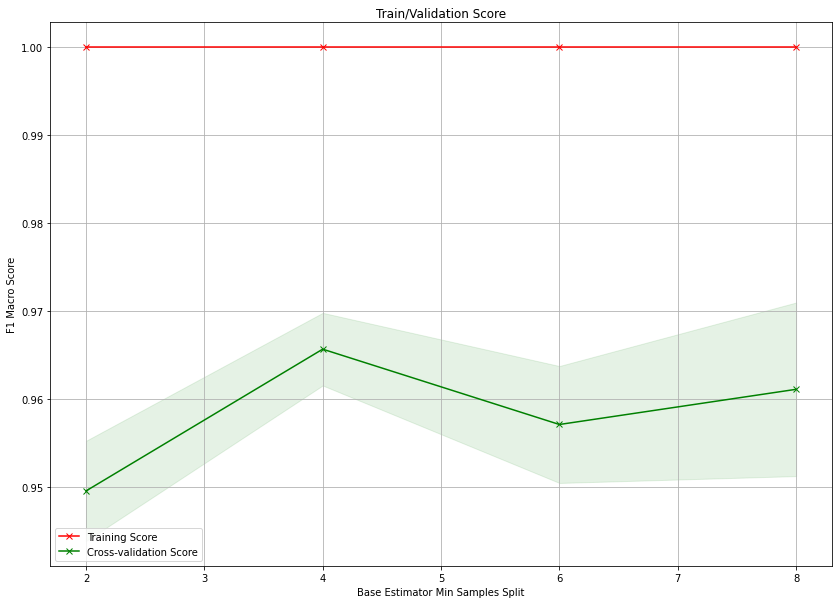

In [32]:
plot_learning_curve_hyper(df_base_min_split, 'Base Estimator Min Samples Split', 
                          'F1 Macro Score', 'Train/Validation Score')

In [33]:
#Optimizing Base Estimator Parameters

base_est = DecisionTreeClassifier(random_state=0)

param_grid = {'base_estimator__min_samples_leaf': [i for i in range(1,17,2)]}

clf_ada = AdaBoostClassifier(base_estimator=base_est, random_state=0)

grid_search = GridSearchCV(clf_ada, param_grid= param_grid,
                           scoring = 'f1_macro', return_train_score=True, cv=5)

grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0),
                                          random_state=0),
             param_grid={'base_estimator__min_samples_leaf': [1, 3, 5, 7, 9, 11,
                                                              13, 15]},
             return_train_score=True, scoring='f1_macro')

In [34]:
df_base_min_leaf = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'base_estimator__min_samples_leaf': 5}

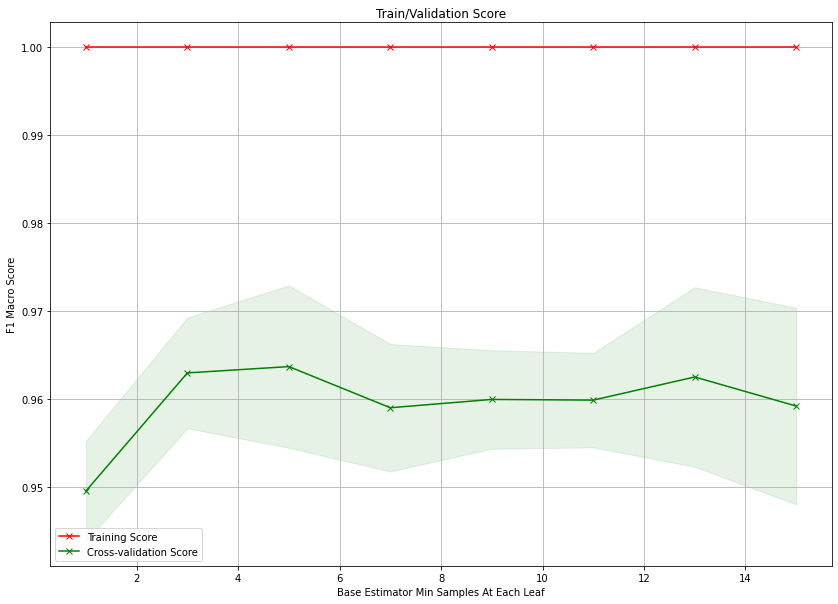

In [35]:
plot_learning_curve_hyper(df_base_min_leaf, 'Base Estimator Min Samples At Each Leaf', 
                          'F1 Macro Score', 'Train/Validation Score')

In [36]:
#Check Accuracy with Optimized Base Estimator
base_est = DecisionTreeClassifier(random_state=0, min_samples_split=4,
                                  min_samples_leaf=5, max_depth=7)

clf_ada_base = AdaBoostClassifier(random_state=0, base_estimator=base_est)


clf_ada_base = clf_ada_base.fit(X_train, y_train)

y_pred_base = clf_ada_base.predict(X_test)

In [37]:
print(f'Classification Report on Test using Optimal Adaboost(Decision Tree):\n\n {classification_report(y_pred_base, y_test, zero_division=1)}')

Classification Report on Test using Optimal Adaboost(Decision Tree):

               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1135
           1       0.92      0.96      0.94       115

    accuracy                           0.99      1250
   macro avg       0.96      0.97      0.96      1250
weighted avg       0.99      0.99      0.99      1250



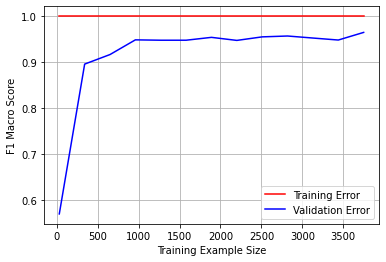

In [38]:
plot_learning_curve(clf_ada_base, X,y)

In [39]:
y_predTrain_base = clf_ada_base.predict(X_train)
print(f'Classification Report on Test using Optimal Adaboost(Decision Tree):\n\n {classification_report(y_predTrain_base, y_train, zero_division=1)}')

Classification Report on Test using Optimal Adaboost(Decision Tree):

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3390
           1       1.00      1.00      1.00       360

    accuracy                           1.00      3750
   macro avg       1.00      1.00      1.00      3750
weighted avg       1.00      1.00      1.00      3750



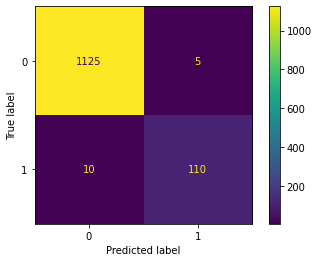

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_base)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
#Optimizing Adaboost algo parameters

base_est = DecisionTreeClassifier(random_state=0, min_samples_split=4,
                                  min_samples_leaf=5, max_depth=7)

param_grid = [{'learning_rate': np.arange(0.001,0.01,0.001)}]

ada_clf_est = AdaBoostClassifier(random_state=0, base_estimator=base_est)


grid_search = GridSearchCV(ada_clf_est, param_grid= param_grid,
                           scoring = 'f1_macro', return_train_score=True,
                           cv=5, n_jobs= -1)

grid_search.fit(X_train, y_train)

In [ ]:
df_ada_learning_rate = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

In [ ]:
plot_learning_curve_hyper(df_ada_learning_rate, 'Adaboost learning rate', 'F1 Macro Score', 'Train/Validation Score')

In [ ]:
#Optimizing Adaboost algo parameters

base_est = DecisionTreeClassifier(random_state=0, min_samples_split=4,
                                  min_samples_leaf=5, max_depth=7)

param_grid = [{'n_estimators': [i for i in range(50,70,1)]}]

ada_clf_est = AdaBoostClassifier(random_state=0, base_estimator=base_est)


grid_search = GridSearchCV(ada_clf_est, param_grid= param_grid,
                           scoring = 'f1_macro', return_train_score=True,
                           cv=5, n_jobs= -1)

grid_search.fit(X_train, y_train)

In [ ]:
df_ada_n_estimators = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

In [ ]:
plot_learning_curve_hyper(df_ada_n_estimators, 'Adaboost n_estimators', 'F1 Macro Score', 'Train/Validation Score')

In [ ]:
#Optimizing Adaboost algo parameters

base_est = DecisionTreeClassifier(random_state=0, min_samples_split=4,
                                  min_samples_leaf=5, max_depth=7)

param_grid = [{'algorithm': ['SAMME', 'SAMME.R']}]

ada_clf_est = AdaBoostClassifier(random_state=0, base_estimator=base_est)


grid_search = GridSearchCV(ada_clf_est, param_grid= param_grid,
                           scoring = 'f1_macro', return_train_score=True,
                           cv=5, n_jobs= -1)

grid_search.fit(X_train, y_train)

In [ ]:
df_ada_algo = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

In [ ]:
plot_learning_curve_hyper(df_ada_algo, 'Adaboost Algorithm', 'F1 Macro Score', 'Train/Validation Score')

In [ ]:
base_est = DecisionTreeClassifier(random_state=0, min_samples_split=4,
                                  min_samples_leaf=5, max_depth=7)

clf_ada_final = AdaBoostClassifier(base_estimator=base_est, random_state=0, n_estimators=56,
                             learning_rate=0.004, algorithm='SAMME')

clf_ada_final.fit(X_train, y_train)

In [ ]:
y_pred_final_model = clf_ada_final.predict(X_test)  

In [ ]:
print(f'Classification Report on Test using Naive Adaboost(Decision Tree):\n\n {classification_report(y_pred_final_model, y_test, zero_division=1)}')

In [ ]:
plot_learning_curve(clf_ada_final, X,y)

In [ ]:
y_predTrain_final_model = clf_ada_final.predict(X_train) 
print(f'Classification Report on Test using Naive Adaboost(Decision Tree):\n\n {classification_report(y_predTrain_final_model, y_train, zero_division=1)}')